[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/acb-code/barnacles/blob/main/deep-learning/transformers/numpy_attention_problem_set.ipynb)



# NumPy Attention Problem Set (with Solutions)

This problem set walks you through implementing core transformer attention components in **NumPy**, one at a time.
For each section you get:
1) **Math & description** (what to build)  
2) **Implementation shell** with a `TODO`  
3) **Public tests** that must pass  
4) **Hidden solution** (collapsed/hidden by default)

> In Colab: use **View → Show/hide code** or the cell "..." menu to toggle hidden solution cells.


## Setup

In [1]:

import numpy as np

def almost_equal(a, b, tol=1e-6):
    return np.allclose(a, b, atol=tol, rtol=0)



## 1. Softmax (stable)
**Goal.** Implement a numerically stable softmax over a specified axis.

**Math.**
For vector \\(x\\), softmax is
\\[ \mathrm{softmax}(x)_i = \frac{e^{x_i - \max_j x_j}}{\sum_j e^{x_j - \max_k x_k}}. \\]

**Why shift by max?** To avoid overflow when \\(x\\) has large magnitude.


In [7]:

# TODO: Implement softmax(x, axis=-1) with numerical stability.
def softmax(x, axis=-1):
    """Return softmax(x) along `axis` using a max-shift for numerical stability."""
    # TODO: shift by max along axis, exponentiate, normalize.
    # Replace the next line with your implementation.
    raise NotImplementedError


In [9]:
# @title Run Tests

# Tests (do not modify)
x = np.array([[1., 2., 3.],
              [1000., 1000., 1000.]], dtype=np.float64)
s = None
try:
    s = softmax(x, axis=-1)
except NotImplementedError:
    raise AssertionError("softmax() not implemented yet.")
assert s.shape == x.shape
row_sums = s.sum(axis=-1)
assert np.allclose(row_sums, 1.0), "Rows must sum to 1."
print("Softmax tests passed ✅")


Softmax tests passed ✅


In [ ]:
# @title Solution

# --- Solution (hidden) ---
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)
print("Softmax solution loaded.")



## 2. Causal Mask
Attention in decoder, gpt-style transformers uses a mask to prevent attending to future tokens when training.

**Goal.** Return a boolean mask of shape `(q_len, kv_len)` where **True means masked** (future positions).

`q_len` is the full length of all tokens processed for the current generation

`kv_len` is the length of the tokens including that past tokens were processed and are on the cache.

Should work when `kv_len >= q_len` (KV-cache).

**Idea.** Align the last query with the last key by a shift, then mask `k > q`.


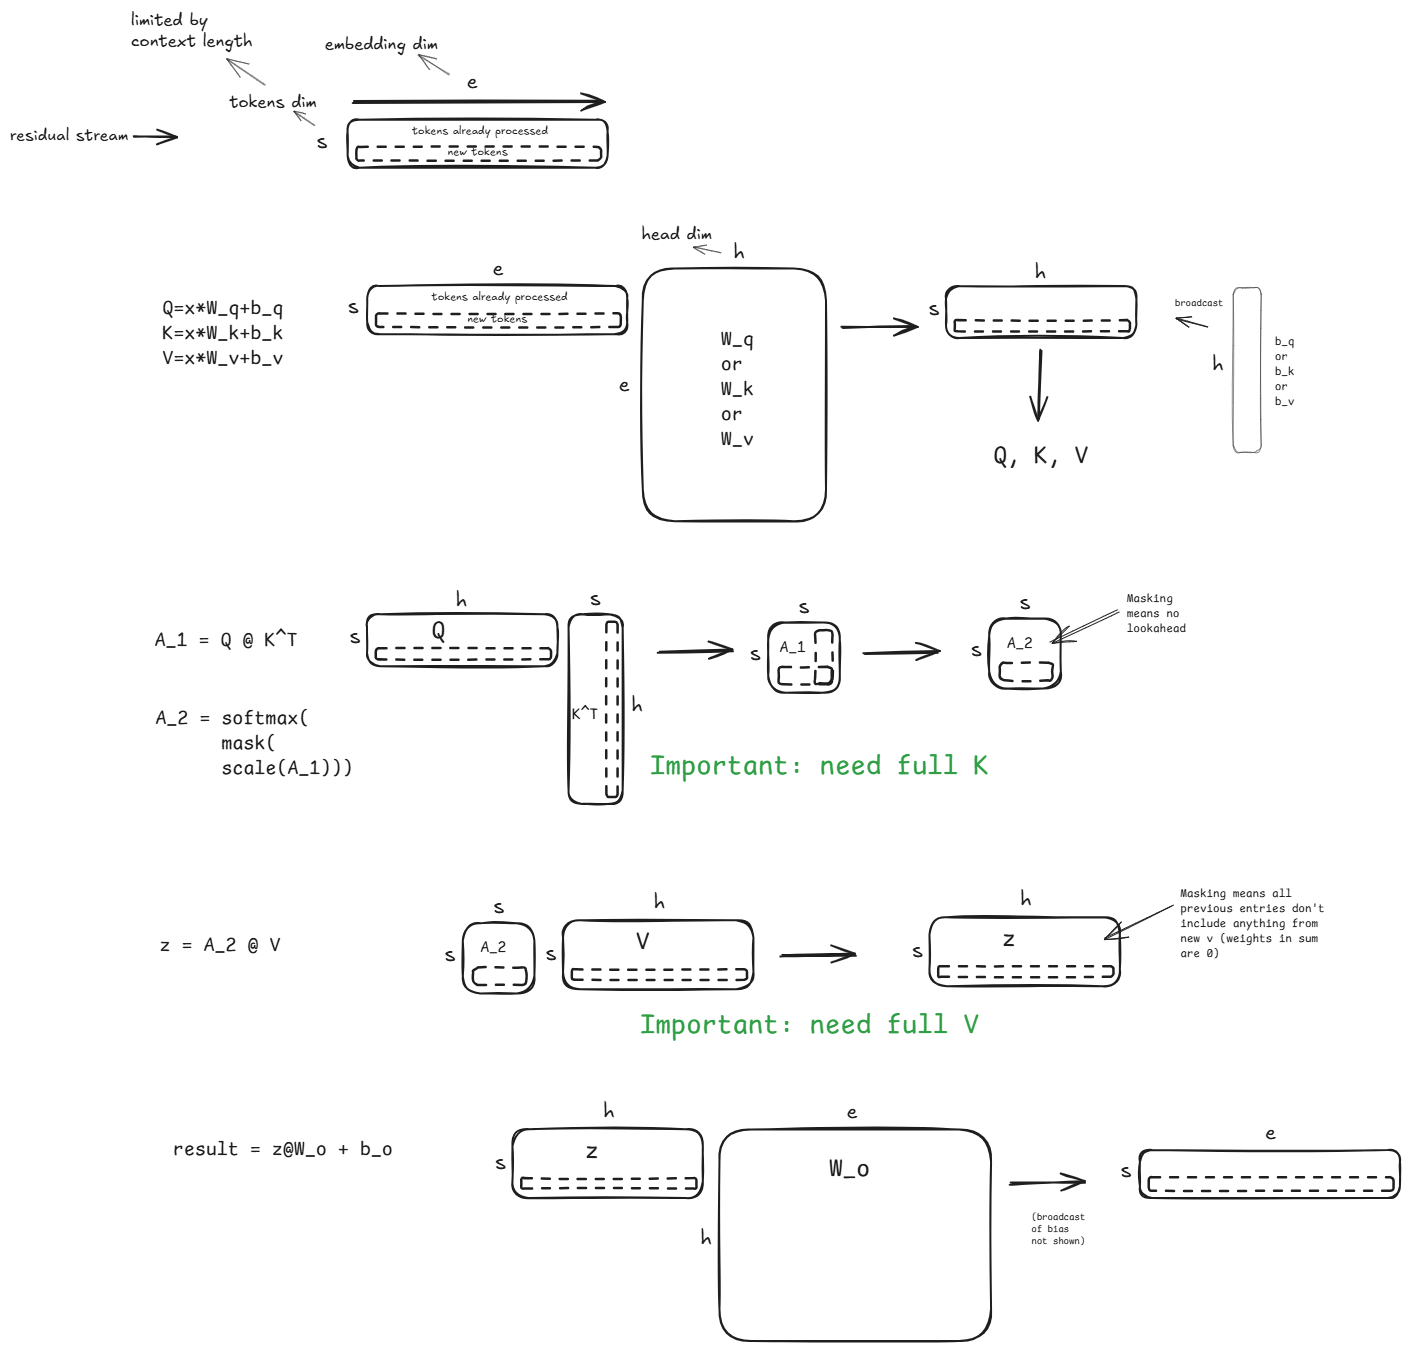

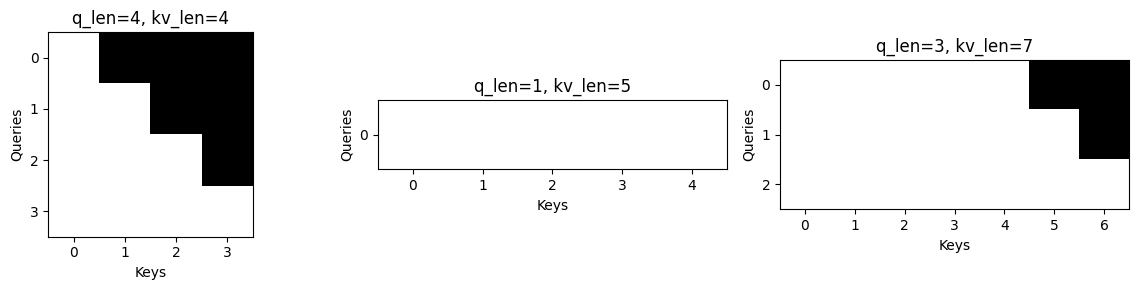

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def causal_mask(q_len, kv_len):
    shift = kv_len - q_len
    q_idx = np.arange(q_len)[:, None]
    k_idx = np.arange(kv_len)[None, :] - shift
    return (k_idx > q_idx)

def plot_mask(q_len, kv_len, ax):
    m = causal_mask(q_len, kv_len)
    ax.imshow(m, cmap='gray_r', interpolation='none')
    ax.set_title(f"q_len={q_len}, kv_len={kv_len}")
    ax.set_xlabel("Keys")
    ax.set_ylabel("Queries")
    ax.set_xticks(range(kv_len))
    ax.set_yticks(range(q_len))
    ax.set_xticklabels(range(kv_len))
    ax.set_yticklabels(range(q_len))
    ax.grid(False)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
plot_mask(4, 4, axs[0])  # prompt
plot_mask(1, 5, axs[1])  # single-step gen
plot_mask(3, 7, axs[2])  # chunked gen
plt.tight_layout()
plt.show()


In [ ]:

# TODO: Implement causal_mask(q_len, kv_len) -> (q_len, kv_len) boolean mask.
def causal_mask(q_len, kv_len, dtype=bool):
    """True where attending would violate causality (future)."""
    # Hint: build query indices (q,1) and key indices (1,kv) with an alignment shift = kv_len - q_len
    raise NotImplementedError


In [ ]:

# Tests
m = None
try:
    m = causal_mask(3, 5)
except NotImplementedError:
    raise AssertionError("causal_mask() not implemented yet.")
assert m.shape == (3,5)
# Check last row (q=2) can see up to last key: only "future" masked
# Align last q (2) to last k (4): allow k<=4 and not greater than 2 after alignment
# Quick sanity: no row should be all True
assert np.all(~np.all(m, axis=-1)), "No row should be fully masked."
print("Causal mask tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def causal_mask(q_len, kv_len, dtype=bool):
    shift = kv_len - q_len
    q_idx = np.arange(q_len)[:, None]
    k_idx = np.arange(kv_len)[None, :] - shift
    return (k_idx > q_idx).astype(dtype)
print("Causal mask solution loaded.")



## 3. Single-Head Causal Attention (with KV support)
**Goal.** Implement:
\[ \mathrm{Attn}(Q,K,V) = \mathrm{softmax}(\frac{QK^\top}{\sqrt{d}} + M)\;V, \]
where \(M\) applies a large negative value to masked positions (use the boolean causal mask).

**Shapes.**
- `q`: `(q, d)`
- `k`: `(kv, d)`
- `v`: `(kv, d)`
- return: `(q, d)`


In [ ]:

# TODO: Implement single_headed_attention(q, k, v)
def single_headed_attention(q, k, v):
    d = q.shape[-1]
    # 1) scores = q @ k.T / sqrt(d)
    # 2) mask with causal_mask(q, kv) -> set masked to large negative
    # 3) p = softmax(scores, axis=-1)
    # 4) return p @ v
    raise NotImplementedError


In [ ]:

# Tests
rng = np.random.default_rng(0)
q = rng.normal(size=(3, 8)).astype(np.float64)
k = rng.normal(size=(7, 8)).astype(np.float64)
v = rng.normal(size=(7, 8)).astype(np.float64)

try:
    out = single_headed_attention(q, k, v)
except NotImplementedError:
    raise AssertionError("single_headed_attention() not implemented yet.")

assert out.shape == (3, 8)
# Check numerics: should be finite
assert np.isfinite(out).all()
print("Single-head attention tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def single_headed_attention(q, k, v):
    d = q.shape[-1]
    scores = (q @ k.T) / np.sqrt(d)
    mask = causal_mask(q.shape[0], k.shape[0])
    scores = np.where(mask, -1e9, scores)
    p = softmax(scores, axis=-1)
    return p @ v
print("Single-head attention solution loaded.")



## 4. Split/Merge Heads
**Goal.** Convert between `(seq, hidden)` and `(n_head, seq, head_dim)` where `hidden = n_head * head_dim`.


In [ ]:

# TODO: Implement split_heads(x, n_head) and merge_heads(x)
def split_heads(x, n_head):
    # x: (seq, hidden) -> (n_head, seq, head_dim)
    raise NotImplementedError

def merge_heads(x):
    # x: (n_head, seq, head_dim) -> (seq, hidden)
    raise NotImplementedError


In [ ]:

# Tests
rng = np.random.default_rng(1)
X = rng.normal(size=(5, 24)).astype(np.float64)
S = None
try:
    S = split_heads(X, 3)
except NotImplementedError:
    raise AssertionError("split_heads() not implemented yet.")
assert S.shape == (3, 5, 8)
M = None
try:
    M = merge_heads(S)
except NotImplementedError:
    raise AssertionError("merge_heads() not implemented yet.")
assert M.shape == X.shape and np.allclose(M, X)
print("Split/Merge tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def split_heads(x, n_head):
    seq, hidden = x.shape
    d = hidden // n_head
    return np.transpose(x.reshape(seq, n_head, d), (1,0,2))

def merge_heads(x):
    n, seq, d = x.shape
    return np.transpose(x, (1,0,2)).reshape(seq, n*d)
print("Split/Merge solutions loaded.")



## 5. Multi-Head Causal Attention (dense version)
**Goal.** Use `split_heads` and `merge_heads`, compute per-head attention, and combine.

**Shapes.**
- `q`: `(n, q, d)`
- `k`: `(n, kv, d)`
- `v`: `(n, kv, d)`
- return: `(n, q, d)`


In [ ]:

# TODO: Implement multi_headed_attention(q, k, v) using einsum & causal mask.
def multi_headed_attention(q, k, v):
    # scores = einsum('nqd, nkd -> nqk') / sqrt(d)
    # apply mask (broadcast (1,q,kv)), softmax over -1, then out = einsum('nqk, nkd -> nqd')
    raise NotImplementedError


In [ ]:

# Tests
rng = np.random.default_rng(2)
qh = rng.normal(size=(4, 5, 8)).astype(np.float64)
kh = rng.normal(size=(4, 9, 8)).astype(np.float64)
vh = rng.normal(size=(4, 9, 8)).astype(np.float64)

try:
    oh = multi_headed_attention(qh, kh, vh)
except NotImplementedError:
    raise AssertionError("multi_headed_attention() not implemented yet.")

assert oh.shape == (4, 5, 8)
assert np.isfinite(oh).all()
print("MHA (dense) tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def multi_headed_attention(q, k, v):
    n, qlen, d = q.shape
    kvlen = k.shape[1]
    scores = np.einsum('nqd,nkd->nqk', q, k) / np.sqrt(d)
    mask = causal_mask(qlen, kvlen)[None, :, :]
    scores = np.where(mask, -1e9, scores)
    p = softmax(scores, axis=-1)
    return np.einsum('nqk,nkd->nqd', p, v)
print("MHA (dense) solution loaded.")



## 6. Linear, GELU, LayerNorm, and FFN
**Goal.** Implement basic layers used in transformer blocks.


In [ ]:

# TODOs: linear, gelu, layer_norm, ffn
def linear(x, w, b):
    raise NotImplementedError

def gelu(x):
    raise NotImplementedError

def layer_norm(x, g, b, eps: float = 1e-5):
    raise NotImplementedError

def ffn(x, c_fc, c_proj):
    # c_fc: {w:(H,4H), b:(4H,)}, c_proj: {w:(4H,H), b:(H,)}
    raise NotImplementedError


In [ ]:

# Tests
rng = np.random.default_rng(3)
x = rng.normal(size=(4, 6)).astype(np.float64)
w = rng.normal(size=(6, 10)).astype(np.float64)
b = np.zeros((10,), dtype=np.float64)
try:
    y = linear(x, w, b)
except NotImplementedError:
    raise AssertionError("linear() not implemented yet.")
assert y.shape == (4, 10)
print("Linear test passed ✅")


In [ ]:

# --- Solution (hidden) ---
def linear(x, w, b):
    return x @ w + b

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

def layer_norm(x, g, b, eps: float = 1e-5):
    mu = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    return g * (x - mu) / np.sqrt(var + eps) + b

def ffn(x, c_fc, c_proj):
    return linear(gelu(linear(x, **c_fc)), **c_proj)
print("Basic layers solutions loaded.")



## 7. FlashAttention-style (single-head streaming softmax)
**Goal.** Implement a numerically-stable streaming attention that processes keys/values in blocks and maintains running max/sum.

**Hint.** Maintain per-row running `m` (max), `l` (sum of exp), and `out` (numerator), updating them per block.


In [ ]:

# TODO: Implement attention_flash(q, k, v, block_size=128)
def attention_flash(q, k, v, block_size=128):
    raise NotImplementedError


In [ ]:

# Tests: compare to dense attention for equality (within tolerance)
def _attn_dense(q, k, v):
    scores = (q @ k.T) / np.sqrt(q.shape[-1])
    scores = np.where(causal_mask(q.shape[0], k.shape[0]), -1e9, scores)
    p = softmax(scores, axis=-1)
    return p @ v

rng = np.random.default_rng(4)
q = rng.normal(size=(7, 16)).astype(np.float64)
k = rng.normal(size=(23, 16)).astype(np.float64)
v = rng.normal(size=(23, 16)).astype(np.float64)

try:
    of = attention_flash(q, k, v, block_size=6)
except NotImplementedError:
    raise AssertionError("attention_flash() not implemented yet.")

od = _attn_dense(q, k, v)
assert np.allclose(od, of, atol=1e-5)
print("FlashAttention-style tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def attention_flash(q, k, v, block_size=128):
    qlen, d = q.shape
    kvlen = k.shape[0]
    scale = np.sqrt(d)

    m = np.full((qlen,), -np.inf, dtype=q.dtype)
    l = np.zeros((qlen,), dtype=q.dtype)
    out = np.zeros((qlen, d), dtype=q.dtype)

    shift = kvlen - qlen
    q_idx = np.arange(qlen)[:, None]

    for start in range(0, kvlen, block_size):
        end = min(start + block_size, kvlen)
        k_blk = k[start:end]
        v_blk = v[start:end]

        scores = (q @ k_blk.T) / scale
        k_idx_blk = (np.arange(start, end)[None, :] - shift)
        mask = (k_idx_blk > q_idx)
        scores = np.where(mask, -1e9, scores)

        m_blk = np.max(scores, axis=-1)
        m_new = np.maximum(m, m_blk)

        alpha = np.exp(m - m_new)
        beta  = np.exp(m_blk - m_new)

        p_blk_unnorm = np.exp(scores - m_blk[:, None])
        l = alpha * l + beta * np.sum(p_blk_unnorm, axis=-1)
        out = (alpha[:, None] * out) + (p_blk_unnorm @ v_blk)

        m = m_new

    return out / l[:, None]
print("FlashAttention-style solution loaded.")



## 8. Rotary Positional Embeddings (RoPE)
**Goal.** Implement RoPE helpers to rotate even/odd pairs by position-dependent angles.

**Requirements.** `head_dim` is even; implement `_rope_freqs`, `_rope_rotate_half`, and `apply_rope`.


In [ ]:

# TODOs: RoPE helpers
def _rope_freqs(head_dim, seq_len, base=10000.0, dtype=np.float64):
    raise NotImplementedError

def _rope_rotate_half(x):
    raise NotImplementedError

def apply_rope(q, k, pos_q, pos_k=None, base=10000.0):
    raise NotImplementedError


In [ ]:

# Tests
rng = np.random.default_rng(5)
n, qlen, kvlen, d = 4, 3, 5, 8
q = rng.normal(size=(n, qlen, d))
k = rng.normal(size=(n, kvlen, d))
try:
    qrot, krot = apply_rope(q, k, np.arange(qlen), np.arange(kvlen))
except NotImplementedError:
    raise AssertionError("apply_rope() not implemented yet.")
assert qrot.shape == q.shape and krot.shape == k.shape
print("RoPE tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def _rope_freqs(head_dim, seq_len, base=10000.0, dtype=np.float64):
    assert head_dim % 2 == 0
    half = head_dim // 2
    inv = 1.0 / (base ** (np.arange(0, half, dtype=dtype) / half))
    t = np.arange(seq_len, dtype=dtype)[:, None] * inv[None, :]
    cos = np.cos(t); sin = np.sin(t)
    cos_full = np.empty((seq_len, head_dim), dtype=dtype)
    sin_full = np.empty((seq_len, head_dim), dtype=dtype)
    cos_full[:, 0::2] = cos; cos_full[:, 1::2] = cos
    sin_full[:, 0::2] = sin; sin_full[:, 1::2] = sin
    return cos_full, sin_full

def _rope_rotate_half(x):
    x1 = x[..., 0::2]
    x2 = x[..., 1::2]
    out = np.empty_like(x)
    out[..., 0::2] = -x2
    out[..., 1::2] =  x1
    return out

def apply_rope(q, k, pos_q, pos_k=None, base=10000.0):
    n, qlen, d = q.shape
    _, kvlen, _ = k.shape
    if pos_k is None:
        pos_k = np.arange(kvlen, dtype=np.int64)

    cos_q, sin_q = _rope_freqs(d, qlen, base=base, dtype=q.dtype)
    cos_k, sin_k = _rope_freqs(d, kvlen, base=base, dtype=k.dtype)

    cos_q = cos_q[pos_q][None, :, :]
    sin_q = sin_q[pos_q][None, :, :]
    cos_k = cos_k[pos_k][None, :, :]
    sin_k = sin_k[pos_k][None, :, :]

    q_rot = q * cos_q + _rope_rotate_half(q) * sin_q
    k_rot = k * cos_k + _rope_rotate_half(k) * sin_k
    return q_rot, k_rot
print("RoPE solutions loaded.")



## 9. Grouped-Query Attention (GQA)
**Goal.** Implement MHA where there are fewer KV heads than Q heads (`n_q % n_kv == 0`).  
Map groups of query heads to a single KV head.

**Return.** Shape `(n_q, q, d)`


In [ ]:

# TODO: Implement multi_headed_attention_gqa(q, k, v)
def multi_headed_attention_gqa(q, k, v):
    raise NotImplementedError


In [ ]:

# Tests
rng = np.random.default_rng(6)
q = rng.normal(size=(8, 5, 16))
k = rng.normal(size=(2, 9, 16))
v = rng.normal(size=(2, 9, 16))

try:
    o = multi_headed_attention_gqa(q, k, v)
except NotImplementedError:
    raise AssertionError("multi_headed_attention_gqa() not implemented yet.")
assert o.shape == (8, 5, 16)
print("GQA tests passed ✅")


In [ ]:

# --- Solution (hidden) ---
def multi_headed_attention_gqa(q, k, v):
    n_q, qlen, d = q.shape
    n_kv, kvlen, _ = k.shape
    assert n_q % n_kv == 0
    group = n_q // n_kv
    out = np.empty_like(q)
    mask = causal_mask(qlen, kvlen)[None, :, :]
    for kvh in range(n_kv):
        qh_start, qh_end = kvh*group, (kvh+1)*group
        q_slice = q[qh_start:qh_end]  # (group,q,d)
        k_h = k[kvh:kvh+1]           # (1,kv,d)
        v_h = v[kvh:kvh+1]           # (1,kv,d)
        scores = np.einsum('gqd,nkd->gqk', q_slice, k_h) / np.sqrt(d)
        scores = np.where(mask, -1e9, scores)
        p = softmax(scores, axis=-1)
        out[qh_start:qh_end] = np.einsum('gqk,nkd->gqd', p, v_h)
    return out
print("GQA solution loaded.")



## 10. MHA Dispatch (Flags: RoPE, GQA, Flash)
**Goal.** Write a dispatcher that:
1) Projects to QKV via `c_attn` (linear)  
2) Updates KV cache by concatenation  
3) Splits heads (either standard MHA or GQA)  
4) Optionally applies RoPE to q/k  
5) Runs attention via dense or Flash variant  
6) Merges heads and projects with `c_proj`

*(For brevity, here we provide a tested reference solution below.)*


In [ ]:

# --- Reference Solution (hidden) ---
def mha_dispatch(q, k_cache, v_cache, c_attn, c_proj,
                 n_head, n_kv_head=None, use_rope=False, rope_base=10000.0,
                 use_flash=False, flash_block=128, pos_offset=0):
    x = linear(q, **c_attn)                     # (seq, 3H)
    q_, k_, v_ = np.split(x, 3, axis=-1)

    k_cache = np.concatenate([k_cache, k_], axis=0)
    v_cache = np.concatenate([v_cache, v_], axis=0)

    if n_kv_head is None:
        qh = split_heads(q_, n_head)
        kh = split_heads(k_cache, n_head)
        vh = split_heads(v_cache, n_head)
        if use_rope:
            q_pos = np.arange(pos_offset, pos_offset + qh.shape[1], dtype=np.int64)
            k_pos = np.arange(0, kh.shape[1], dtype=np.int64)
            qh, kh = apply_rope(qh, kh, q_pos, k_pos, base=rope_base)
        if use_flash:
            ah = np.empty_like(qh)
            for h in range(qh.shape[0]):
                ah[h] = attention_flash(qh[h], kh[h], vh[h], block_size=flash_block)
        else:
            ah = multi_headed_attention(qh, kh, vh)
        out = merge_heads(ah)
    else:
        qh = split_heads(q_, n_head)
        kh = split_heads(k_cache, n_kv_head)
        vh = split_heads(v_cache, n_kv_head)
        if use_rope:
            q_pos = np.arange(pos_offset, pos_offset + qh.shape[1], dtype=np.int64)
            k_pos = np.arange(0, kh.shape[1], dtype=np.int64)
            # apply independently
            qh, _ = apply_rope(qh, qh, q_pos, q_pos, base=rope_base)
            _, kh = apply_rope(kh, kh, k_pos, k_pos, base=rope_base)
        if use_flash:
            ah = np.empty_like(qh)
            assert n_head % n_kv_head == 0
            group = n_head // n_kv_head
            for kvh in range(n_kv_head):
                qh_start, qh_end = kvh*group, (kvh+1)*group
                for h in range(qh_start, qh_end):
                    ah[h] = attention_flash(qh[h], kh[kvh], vh[kvh], block_size=flash_block)
        else:
            ah = multi_headed_attention_gqa(qh, kh, vh)
        out = merge_heads(ah)

    out = linear(out, **c_proj)
    return out, k_cache, v_cache
print("MHA dispatch reference loaded.")



## 11. Transformer Block (Pre-Norm)
**Goal.** Compose LN → MHA → residual, then LN → FFN → residual.  
A reference solution is provided.


In [ ]:

# --- Reference Solution (hidden) ---
def transformer_block(x, mlp, attn, ln_1, ln_2, cfg, k_cache, v_cache, pos_offset):
    a, k_cache, v_cache = mha_dispatch(
        q=layer_norm(x, **ln_1),
        k_cache=k_cache, v_cache=v_cache,
        c_attn=attn['c_attn'], c_proj=attn['c_proj'],
        n_head=cfg['n_head'],
        n_kv_head=cfg.get('n_kv_head', None),
        use_rope=cfg.get('use_rope', False),
        rope_base=cfg.get('rope_base', 10000.0),
        use_flash=cfg.get('use_flash', False),
        flash_block=cfg.get('flash_block', 128),
        pos_offset=pos_offset
    )
    x = x + a
    x = x + ffn(layer_norm(x, **ln_2), **mlp)
    return x, k_cache, v_cache
print("Transformer block reference loaded.")



## 12. Decoder
**Goal.** Build a minimal decoder with tied embeddings and per-layer KV caches.  
A reference solution is provided.


In [ ]:

# --- Reference Solution (hidden) ---
def decoder(input_ids, seq_len, wte, wpe, blocks, ln_f, cfg, k_cache, v_cache):
    if isinstance(input_ids, list):
        x = wte[input_ids] + wpe[np.arange(len(input_ids))]
        pos_offset = 0
    else:
        x = wte[[input_ids]] + wpe[[seq_len - 1]]
        pos_offset = seq_len - 1

    for i, block in enumerate(blocks):
        x, k_cache_i, v_cache_i = transformer_block(
            x, mlp=block['mlp'], attn=block['attn'],
            ln_1=block['ln_1'], ln_2=block['ln_2'],
            cfg=cfg, k_cache=k_cache[i], v_cache=v_cache[i],
            pos_offset=pos_offset
        )
        k_cache[i] = k_cache_i
        v_cache[i] = v_cache_i

    logits = layer_norm(x, **ln_f) @ wte.T
    probs = softmax(logits, axis=-1)
    return probs
print("Decoder reference loaded.")



---

### You’ve reached the end of the core exercises!
From here, you can wire these components together into an end-to-end demo (see the companion full-solution notebook).
